In [1]:
!pip install feature-engine

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.1/357.1 kB 8.6 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 89.2 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.2.2
    Uninstalling scikit-learn-1.2.2:
      Successfully uninstalled scikit-learn-1.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
spopt 0.6.0 requires shapely>=2.0.1, but you have shapely 1.8.5.post1 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore') 
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from feature_engine.discretisation import EqualWidthDiscretiser
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import RandomForestRegressor

In [3]:
od_data = od_data = pd.read_csv('/kaggle/input/predict-online-dating-matches-dataset/Online_Dating_Behavior_Dataset.csv')

In [4]:
od_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Gender          1000 non-null   int64
 1   PurchasedVIP    1000 non-null   int64
 2   Income          1000 non-null   int64
 3   Children        1000 non-null   int64
 4   Age             1000 non-null   int64
 5   Attractiveness  1000 non-null   int64
 6   Matches         1000 non-null   int64
dtypes: int64(7)
memory usage: 54.8 KB


In [5]:
od_data.head()

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Matches
0,0,1,51777,3,47,5,70
1,1,0,36646,0,42,7,130
2,0,0,53801,1,25,5,0
3,0,0,56105,0,35,8,0
4,0,0,55597,1,36,6,0


In [6]:
od_data.describe(include='all')

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness,Matches
count,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.00000
mean,0.51000,0.474000,50988.447000,0.978000,34.616000,5.624000,76.05000
std,0.50015,0.499573,9889.336141,0.997251,9.147799,2.824288,52.71315
min,0.00000,0.000000,20786.000000,0.000000,18.000000,1.000000,0.00000
25%,0.00000,0.000000,44358.500000,0.000000,27.000000,3.000000,0.00000
50%,1.00000,0.000000,50841.500000,1.000000,35.000000,6.000000,70.00000
75%,1.00000,1.000000,57396.000000,2.000000,43.000000,8.000000,120.00000
max,1.00000,1.000000,81931.000000,3.000000,49.000000,10.000000,160.00000


In [7]:
od_data.nunique()

Gender              2
PurchasedVIP        2
Income            989
Children            4
Age                32
Attractiveness     10
Matches            11
dtype: int64

In [8]:
od_data.isnull().sum()

Gender            0
PurchasedVIP      0
Income            0
Children          0
Age               0
Attractiveness    0
Matches           0
dtype: int64

In [9]:
od_eda = od_data.copy()

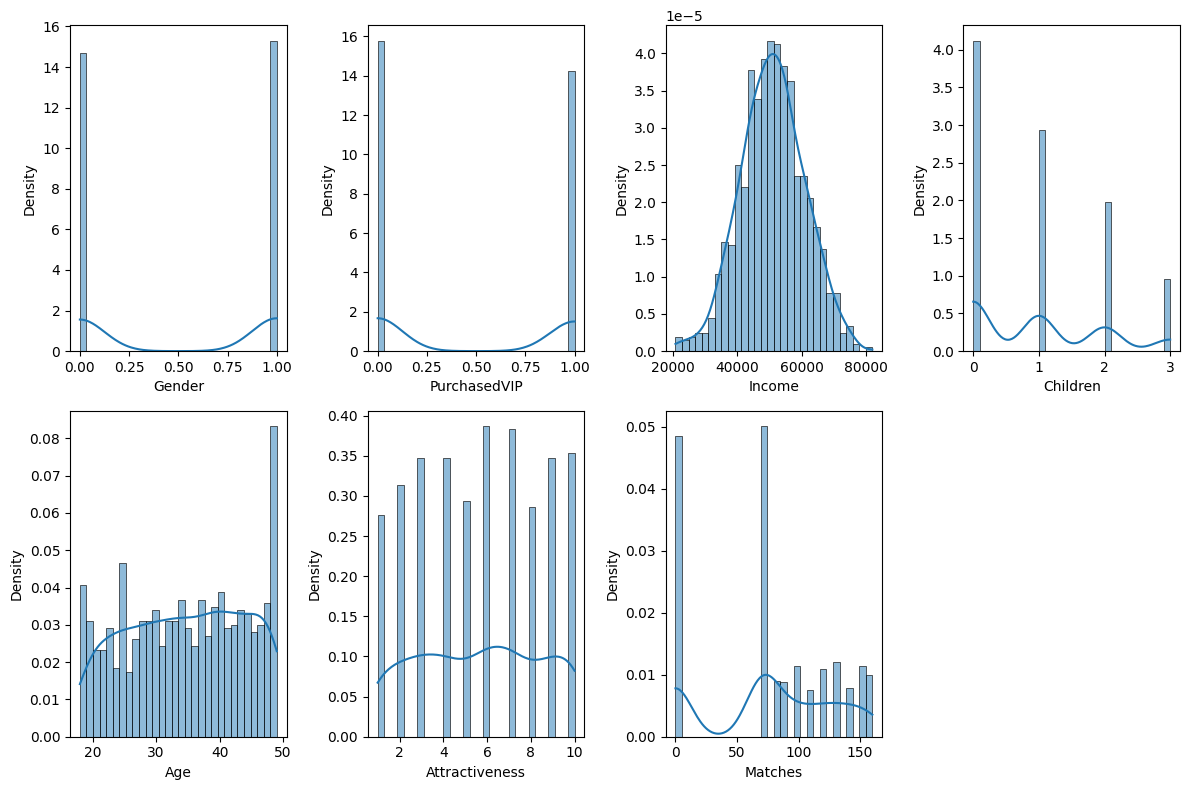

In [10]:
num_cols_eda = od_eda.columns

fig, ax = plt.subplots(2, 4, figsize=(12, 8))
ax = ax.flatten()

for i, col in enumerate(num_cols_eda):
    sns.histplot(od_eda[col],kde=True,stat='density',bins=30,ax=ax[i])
    
for i in range(len(num_cols_eda),8):
    ax[i].axis('off')

plt.tight_layout()
plt.show()

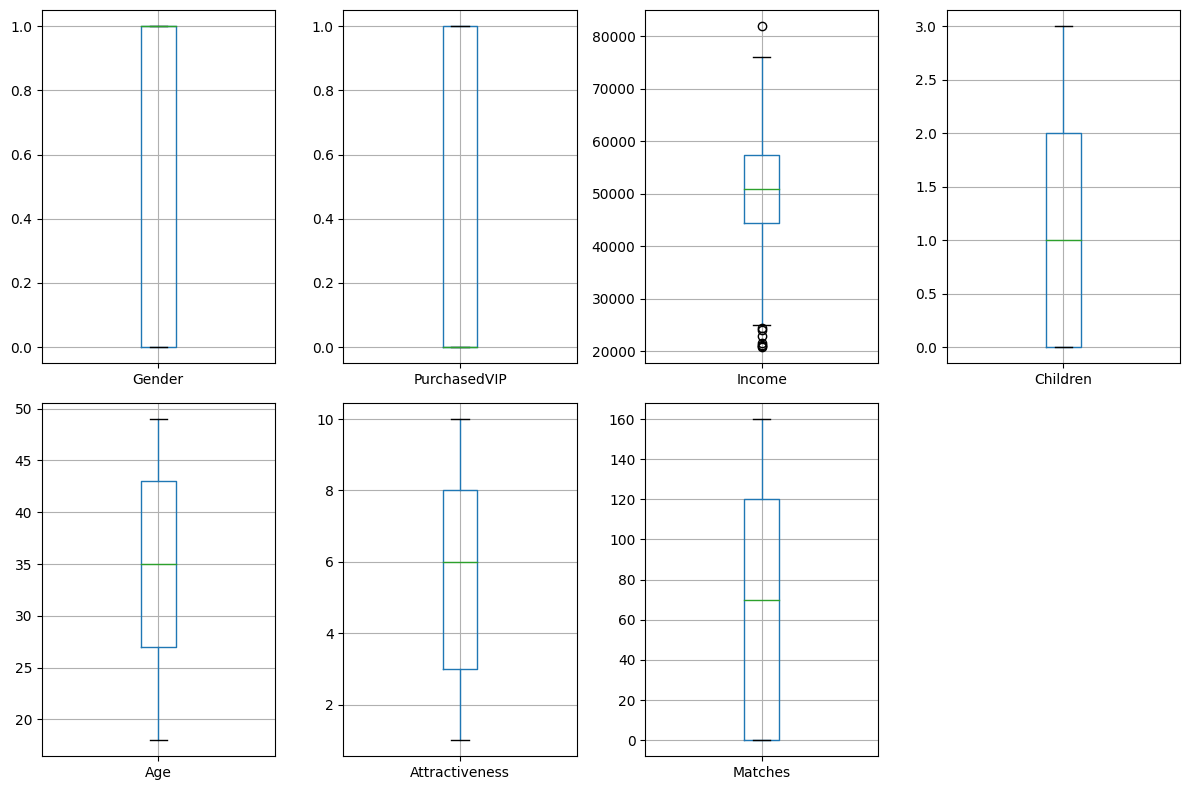

In [11]:
fig, ax = plt.subplots(2, 4, figsize=(12, 8))
ax = ax.flatten()

for i, col in enumerate(num_cols_eda):
    od_eda.boxplot(col, ax=ax[i])
    
for i in range(len(num_cols_eda),8):
    ax[i].axis('off')

plt.tight_layout()
plt.show()

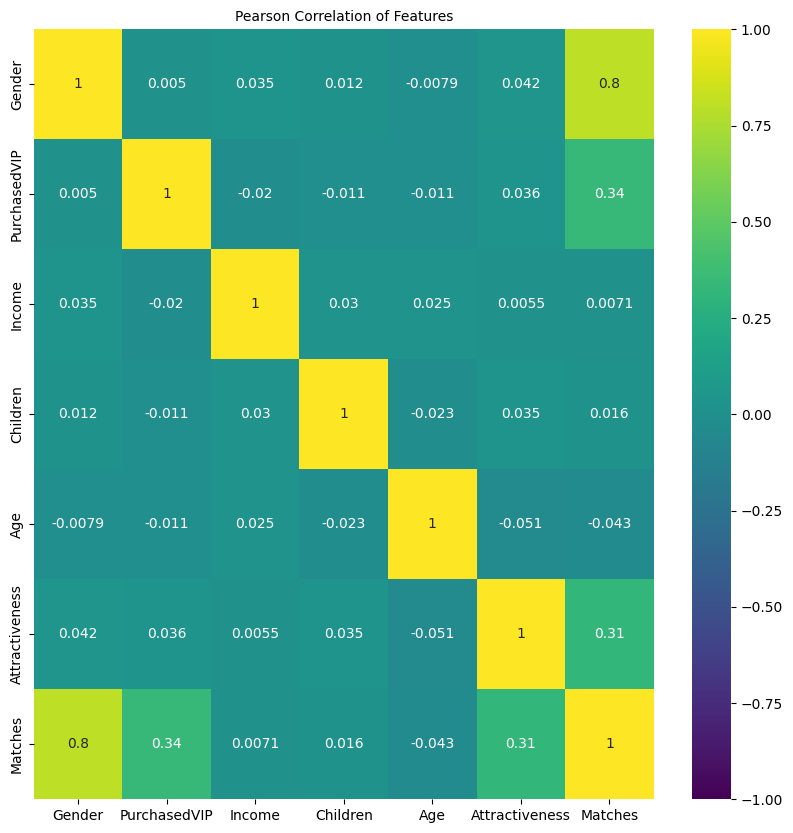

In [12]:
colormap = plt.cm.viridis
plt.figure(figsize=(10,10))
plt.title('Pearson Correlation of Features', size=10)
ax = sns.heatmap(od_eda[num_cols_eda].corr(), cmap=colormap, annot=True,vmin=-1,vmax=1)
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(
    od_data.drop('Matches', axis=1), od_data['Matches'], test_size=0.2, random_state=69)

X_train.shape, X_test.shape

((800, 6), (200, 6))

In [14]:
y_train.shape, y_test.shape

((800,), (200,))

In [15]:
ewq_disc = EqualWidthDiscretiser(bins=5, variables = ['Income','Age'])
ewq_disc.fit(X_train)

EqualWidthDiscretiser(bins=5, variables=['Income', 'Age'])

In [16]:
ewq_disc.binner_dict_

{'Income': [-inf, 32224.8, 43172.6, 54120.399999999994, 65068.2, inf],
 'Age': [-inf, 24.2, 30.4, 36.6, 42.8, inf]}

In [17]:
X_train = ewq_disc.transform(X_train)
X_test = ewq_disc.transform(X_test)

Text(0, 0.5, 'Number of observations per bin')

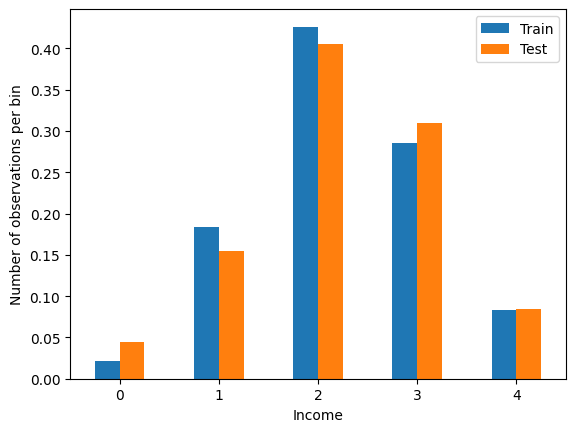

In [18]:
t1 = X_train.groupby(['Income'])['Income'].count() / len(X_train)
t2 = X_test.groupby(['Income'])['Income'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['Train', 'Test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

Text(0, 0.5, 'Number of observations per bin')

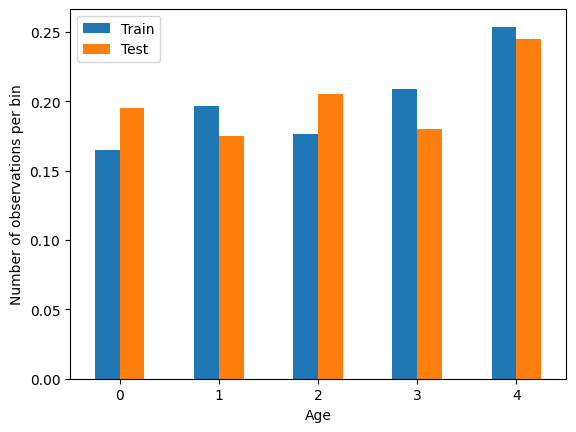

In [19]:
t1 = X_train.groupby(['Age'])['Age'].count() / len(X_train)
t2 = X_test.groupby(['Age'])['Age'].count() / len(X_test)

tmp = pd.concat([t1, t2], axis=1)
tmp.columns = ['Train', 'Test']
tmp.plot.bar()
plt.xticks(rotation=0)
plt.ylabel('Number of observations per bin')

In [20]:
X_train.head()

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness
543,1,0,3,0,3,9
342,0,0,3,1,1,10
10,0,0,3,0,3,3
74,0,0,3,0,4,1
416,0,0,2,0,4,1


In [21]:
X_test.head()

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness
823,0,1,1,1,1,5
999,0,0,1,0,4,3
891,0,1,2,2,1,1
781,0,1,1,3,1,7
967,1,1,3,0,4,10


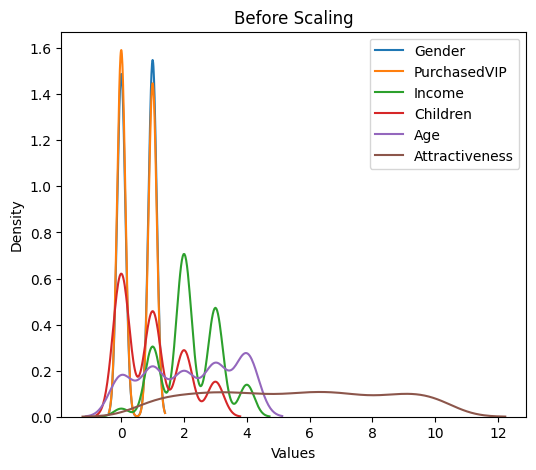

In [22]:
plt.figure(figsize=(6, 5))
plt.title('Before Scaling')
plt.xlabel('Values')
for col in X_train.columns:
    sns.kdeplot(X_train[col], label=col)
plt.legend()
plt.show()

In [23]:
scaler = StandardScaler()

for col in X_train.columns:
    X_train[col] = scaler.fit_transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

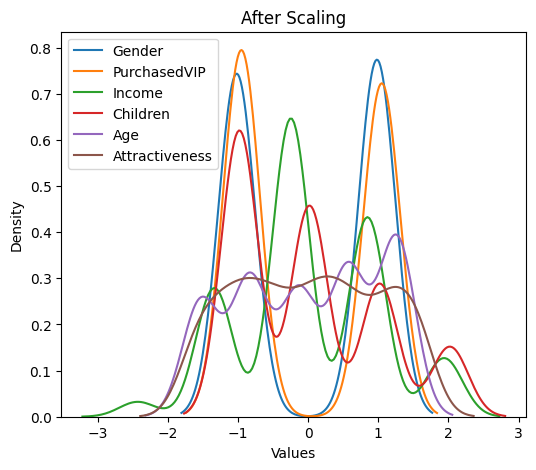

In [24]:
plt.figure(figsize=(6, 5))
plt.title('After Scaling')
plt.xlabel('Values')
for col in X_train.columns:
    sns.kdeplot(X_train[col], label=col)
plt.legend()
plt.show()

In [25]:
X_train.head()

,Gender,PurchasedVIP,Income,Children,Age,Attractiveness
543,0.980196,-0.953576,0.845459,-0.982037,0.566572,1.217374
342,-1.020204,-0.953576,0.845459,0.018765,-0.832371,1.570492
10,-1.020204,-0.953576,0.845459,-0.982037,0.566572,-0.901333
74,-1.020204,-0.953576,0.845459,-0.982037,1.266044,-1.607569
416,-1.020204,-0.953576,-0.247218,-0.982037,1.266044,-1.607569


In [26]:
model_linear_regression = LinearRegression()
model_linear_regression.fit(X_train, y_train)
print('train_mse:', mean_squared_error(y_train, model_linear_regression.predict(X_train)), 
      '\n test_mse:', mean_squared_error(y_test, model_linear_regression.predict(X_test)))
print('train_r-sq:', r2_score(y_train, model_linear_regression.predict(X_train)), 
      '\n test_r-sq:', r2_score(y_test, model_linear_regression.predict(X_test)))

train_mse: 487.992389478345 
 test_mse: 473.7469123502267
train_r-sq: 0.8221446520547186 
 test_r-sq: 0.8367514402234231


In [27]:
rfr = RandomForestRegressor(random_state=69)
rfr.fit(X_train, y_train)
print('train_mse:', mean_squared_error(y_train, rfr.predict(X_train)), 
      '\n test_mse:', mean_squared_error(y_test, rfr.predict(X_test)))
print('train_r-sq:', r2_score(y_train,rfr.predict(X_train)), 
      '\n test_r-sq:', r2_score(y_test, rfr.predict(X_test)))

train_mse: 0.0 
 test_mse: 0.0
train_r-sq: 1.0 
 test_r-sq: 1.0
